---
title: Completitud datos
subtitle: Data operativa
author: Departamento confiabilidad
date: 2025-03-21
---

In [20]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
from pathlib import Path


import pandas as pd
import polars as pl
import dagster as dg
from kdags.resources.dplyr import *
from kdags.resources.tidyr import *
from io import BytesIO
import pdfplumber

from datetime import datetime
import re
import os
from kdags.definitions import *
from kdags.readr import *
import numpy as np

context = dg.build_asset_context()

from kdags.resources.ggplot import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

equipments_names = MasterData.equipments()["equipment_name"].to_list()


def create_equipment_completeness_plot(
    df, date_col="record_dt", equipment_col="equipment_name"
):
    """
    Create a visualization of data completeness by equipment and date using enhanced GGPrism theme.

    Parameters:
    -----------
    df : polars.DataFrame or pandas.DataFrame
        DataFrame containing equipment and date information
    date_col : str
        Name of the date column
    equipment_col : str
        Name of the equipment column

    Returns:
    --------
    tuple: (fig, ax) - matplotlib figure and axes objects
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    import polars as pl
    from kdags.resources.ggplot.ggprism import GGPrism
    import matplotlib.dates as mdates

    # Convert to pandas for easier date handling if using polars
    if isinstance(df, pl.DataFrame):
        pdf = df.to_pandas()
    else:
        pdf = df
    pdf = pdf.loc[pdf[equipment_col].isin(equipments_names)]
    # Ensure date column is datetime
    pdf[date_col] = pd.to_datetime(pdf[date_col])
    pdf = pdf.loc[pdf[date_col] <= datetime.now()]
    # Create a month period column
    pdf["month"] = pdf[date_col].dt.to_period("M")

    # Get unique equipment and months
    equipments = sorted(pdf[equipment_col].unique())
    months = sorted(pdf["month"].unique())

    # Create a pivot table to check data availability
    availability = pdf.groupby([equipment_col, "month"]).size().unstack(fill_value=0)
    availability = (availability > 0).astype(int)

    # Initialize GGPrism theme with custom settings
    theme = GGPrism(base_size=14, base_fontface="bold")

    # Create figure with appropriate aspect ratio
    fig_width = max(
        12, len(months) * 0.25 + 2
    )  # Adjust width based on number of months
    fig_height = max(
        8, len(equipments) * 0.25 + 2
    )  # Adjust height based on number of equipment
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Apply GGPrism theme to the plot
    theme.apply_theme(ax)

    # Generate an array for coloring
    n_equip = len(equipments)
    n_months = len(months)
    has_data_array = np.zeros((n_equip, n_months))

    for i, equipment in enumerate(sorted(availability.index)):
        for j, month in enumerate(availability.columns):
            if equipment in availability.index:
                has_data = availability.loc[equipment, month]
                has_data_array[i, j] = has_data

    # Use enhanced GGPrism colors for the circles
    available_color = "#077E97"  # Bright blue from GGPrism winter_bright palette
    missing_color = "#800080"  # Purple from GGPrism winter_bright palette

    # Set circle size based on plot dimensions
    circle_size = min(0.35, 600 / (n_equip * n_months))

    # Create a scatter plot with circles
    for i in range(n_equip):
        for j in range(n_months):
            has_data = has_data_array[i, j]

            # Draw a circle - filled if data exists, empty if missing
            if has_data:
                circle = Circle((j, i), circle_size, color=available_color, alpha=0.8)
            else:
                circle = Circle(
                    (j, i),
                    circle_size,
                    fill=False,
                    edgecolor=missing_color,
                    linestyle="--",
                    linewidth=1.2,
                )

            ax.add_patch(circle)

    # Set up axis labels
    ax.set_xticks(np.arange(n_months))
    ax.set_yticks(np.arange(n_equip))

    # Format month labels - improve readability
    month_labels = [m.strftime("%Y-%m") for m in months]

    # If we have many months, only show some labels to avoid overcrowding
    if len(months) > 24:
        # Show every nth label
        n = max(1, len(months) // 12)
        shown_indices = list(range(0, len(months), n))
        empty_labels = [""] * len(months)
        for idx in shown_indices:
            if idx < len(month_labels):
                empty_labels[idx] = month_labels[idx]
        month_labels = empty_labels

    ax.set_xticklabels(month_labels, rotation=45, ha="right")

    # Apply GGPrism styling to axis labels
    for tick in ax.get_xticklabels():
        tick.set_fontweight(theme.base_fontface)
        tick.set_color(theme.FIXED_COLORS["axis_color"])
        tick.set_fontsize(theme.axis_text_size)

    for tick in ax.get_yticklabels():
        tick.set_fontweight(theme.base_fontface)
        tick.set_color(theme.FIXED_COLORS["axis_color"])
        tick.set_fontsize(theme.axis_text_size)

    ax.set_yticklabels(sorted(availability.index))

    # Set axis limits to ensure circles are fully visible
    ax.set_xlim(-0.5, n_months - 0.5)
    ax.set_ylim(-0.5, n_equip - 0.5)

    # Add subtle grid
    ax.grid(which="both", color="#EEEEEE", linestyle="-", linewidth=0.5, alpha=0.7)

    # Create legend elements
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=available_color,
            markersize=12,
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="w",
            markeredgecolor=missing_color,
            markersize=12,
            markeredgewidth=1.2,
        ),
    ]

    # Add legend with GGPrism styling
    legend = ax.legend(
        legend_elements,
        ["Data Available", "Data Missing"],
        loc="upper right",
        frameon=True,
    )

    # Apply GGPrism styling to legend
    legend.get_frame().set_linewidth(theme.base_line_size)
    legend.get_frame().set_edgecolor(theme.FIXED_COLORS["axis_color"])

    # Make legend text regular weight
    for text in legend.get_texts():
        text.set_color(theme.FIXED_COLORS["axis_color"])
        text.set_fontsize(theme.legend_text_size)

    # Use GGPrism title and label styling
    ax.set_title(
        "Disponibilidad mensual de datos",
        fontsize=theme.title_size,
        fontweight=theme.base_fontface,
        color=theme.FIXED_COLORS["plot_title_color"],
        pad=20,
    )

    ax.set_xlabel(
        "Mes",
        fontsize=theme.axis_title_size,
        fontweight=theme.base_fontface,
        color=theme.FIXED_COLORS["axis_title_color"],
        labelpad=15,
    )

    ax.set_ylabel(
        "Equipo",
        fontsize=theme.axis_title_size,
        fontweight=theme.base_fontface,
        color=theme.FIXED_COLORS["axis_title_color"],
        labelpad=15,
    )

    # Adjust layout
    plt.tight_layout()

    # Add a bit more padding at the top for the title
    plt.subplots_adjust(top=0.95)

    return fig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
haul_df = Readr.Operation.read_haul(context)

# Completitud datos PLM

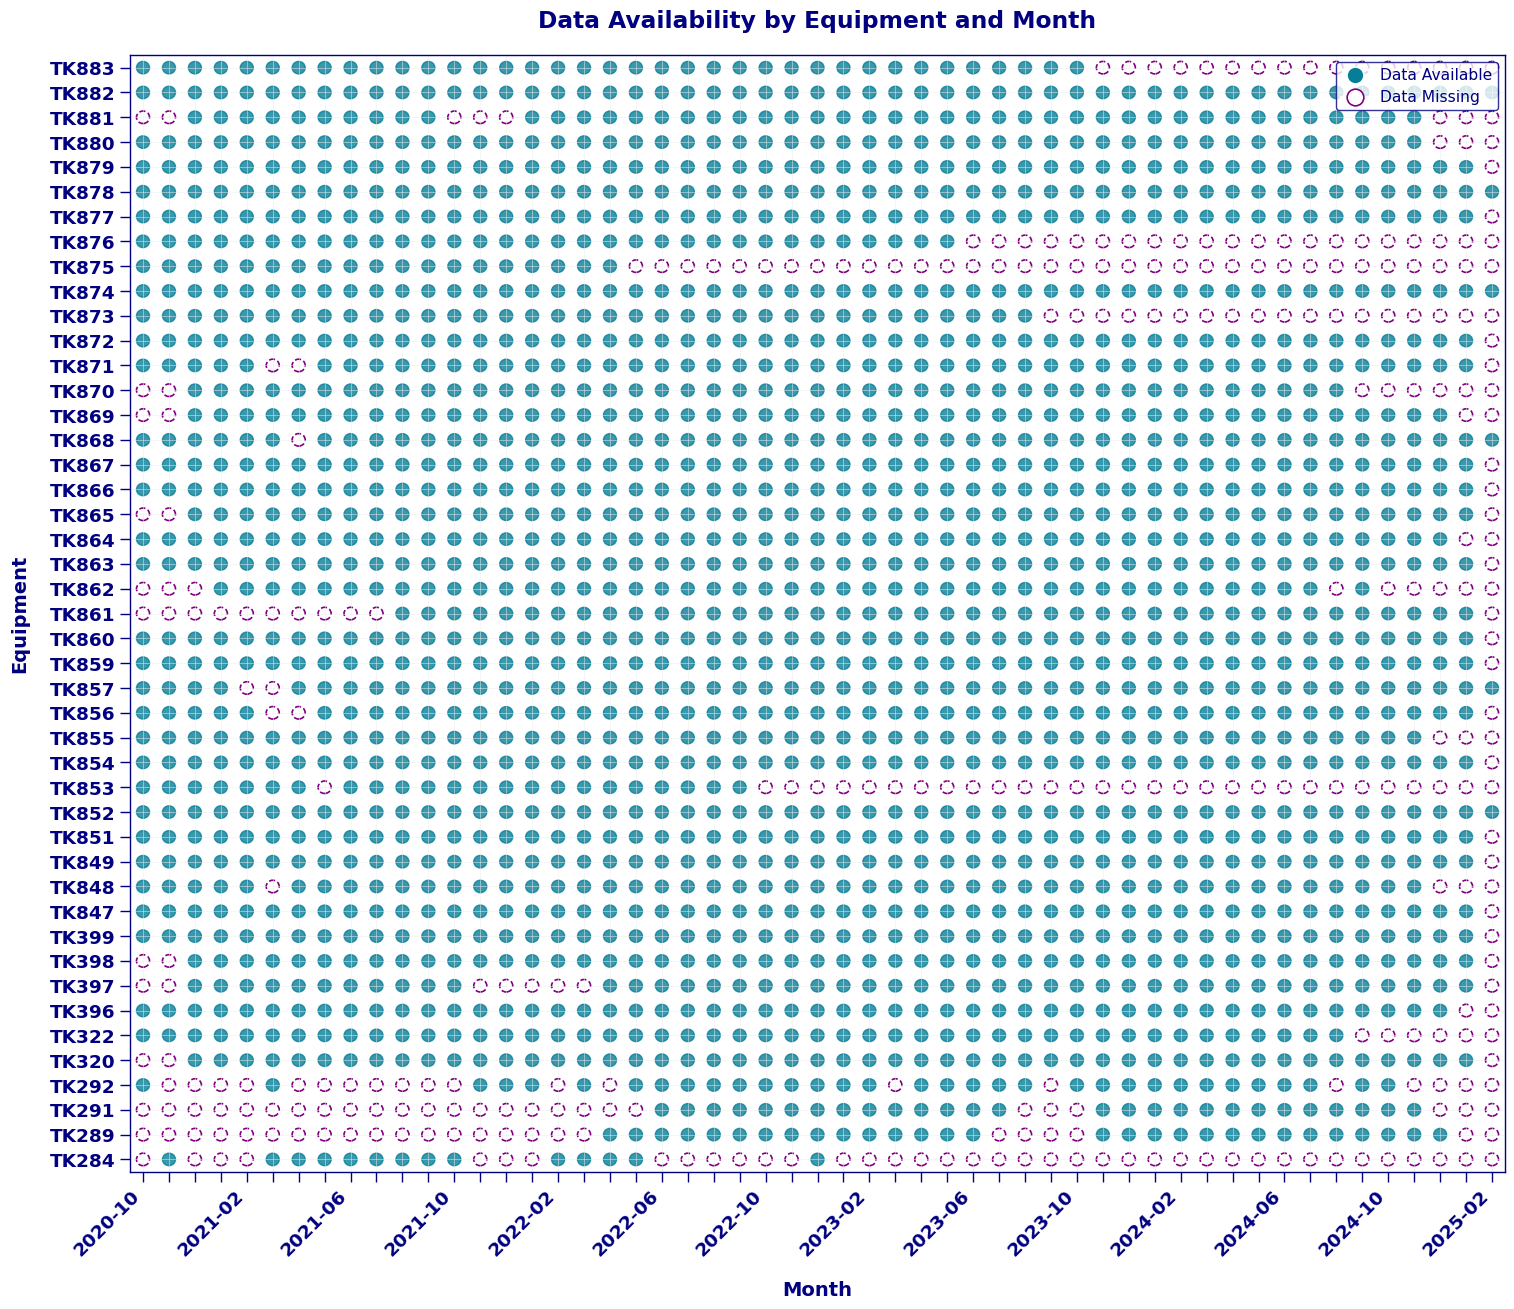

In [23]:
fig = create_equipment_completeness_plot(haul_df.to_pandas())

# Completitud datos GE

In [13]:
ge_df = Readr.Operation.read_events(context)

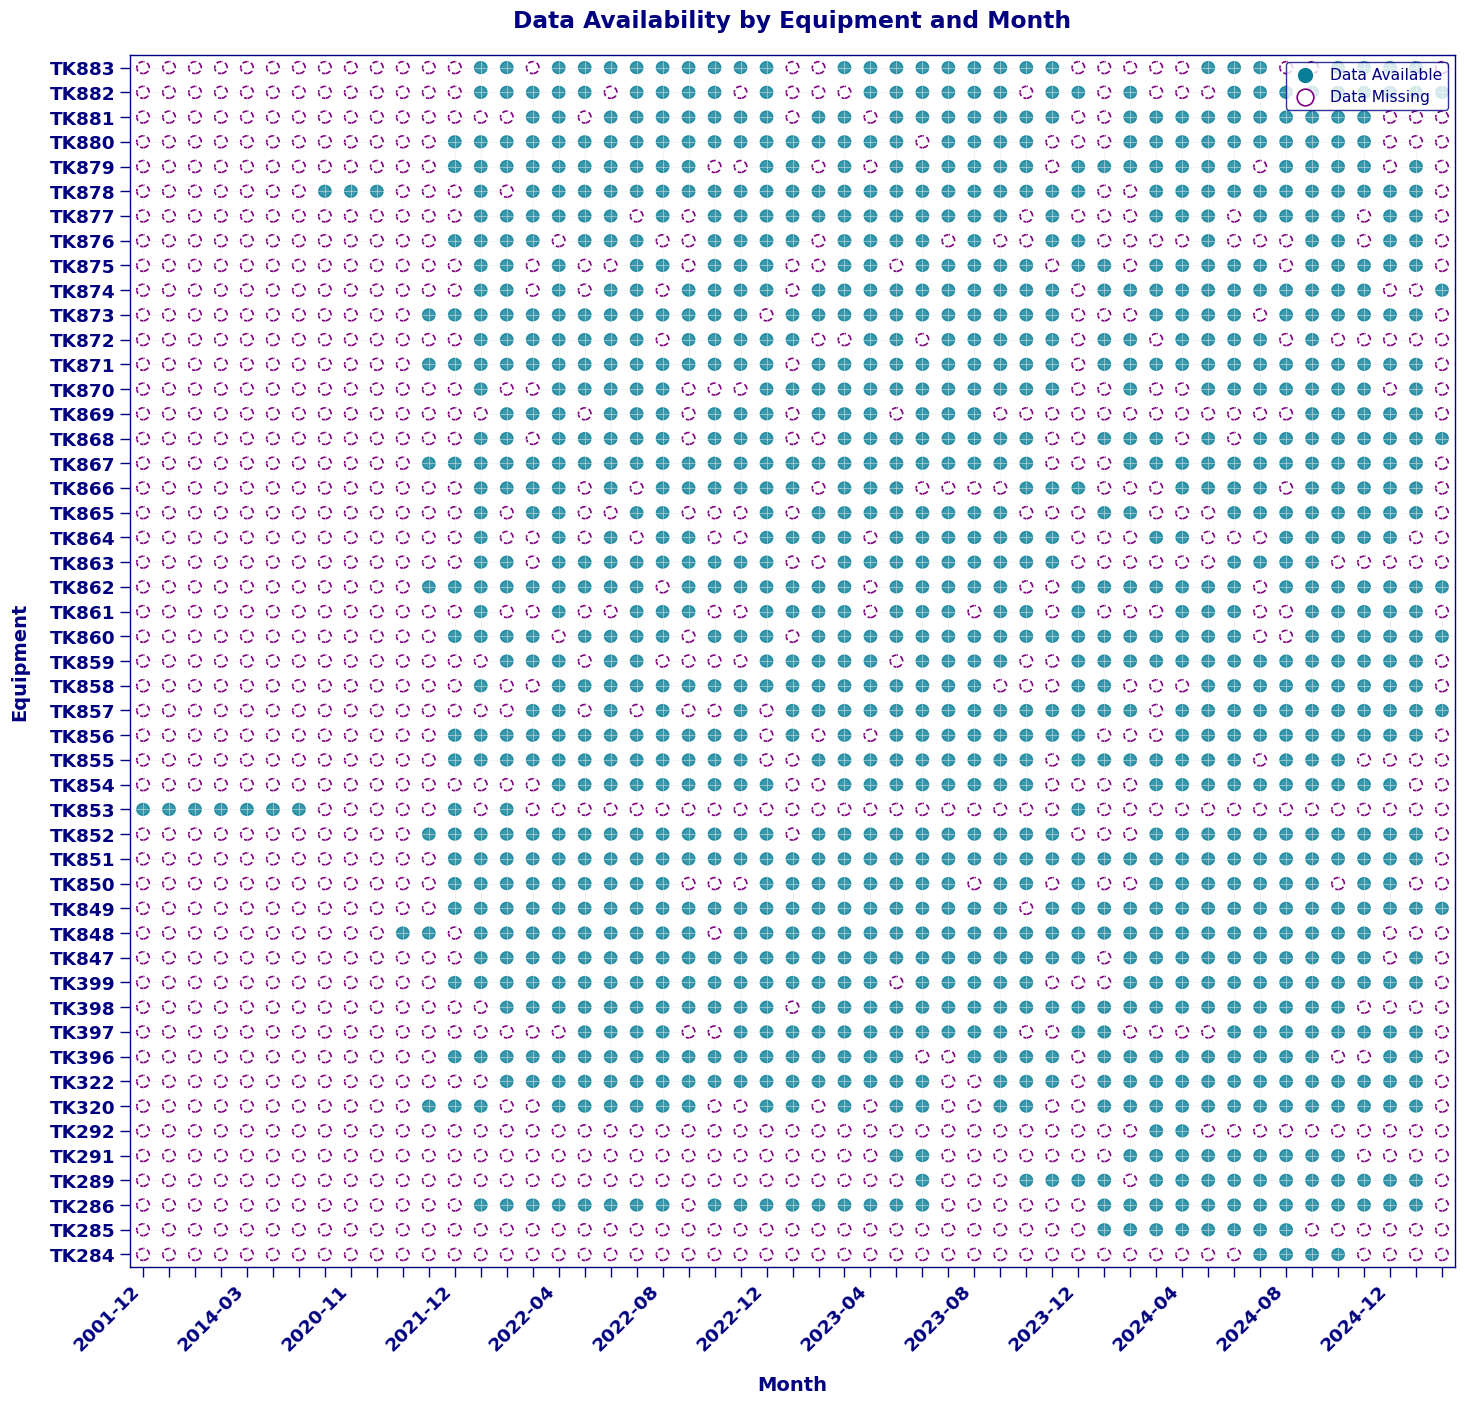

In [24]:
fig = create_equipment_completeness_plot(
    ge_df.to_pandas().dropna(subset=["filepath_equipment_name", "record_dt"]),
    date_col="record_dt",
    equipment_col="filepath_equipment_name",
)